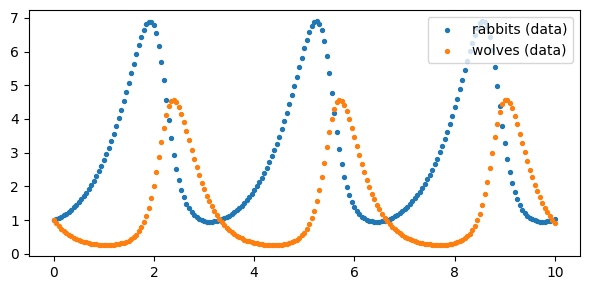

iter    1 | loss=134.525795 | params=[ 3.9   1.1   1.9   0.5  -0.05]


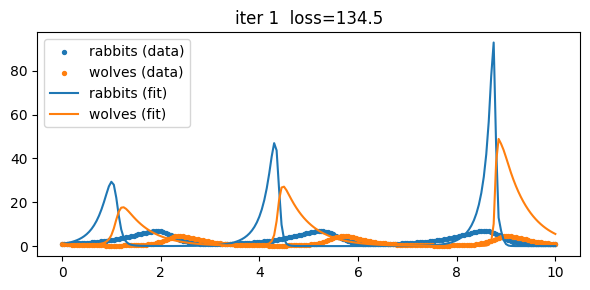

iter  200 | loss=2.573391 | params=[ 3.54022843  1.47292885  2.26200106  0.78438619 -0.54677926]


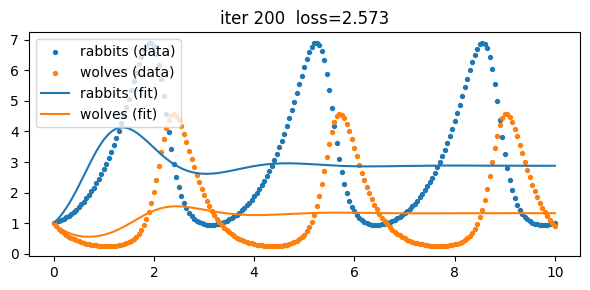

iter  400 | loss=2.457586 | params=[ 3.33176391  1.18082167  2.22201769  0.75409213 -0.50079335]


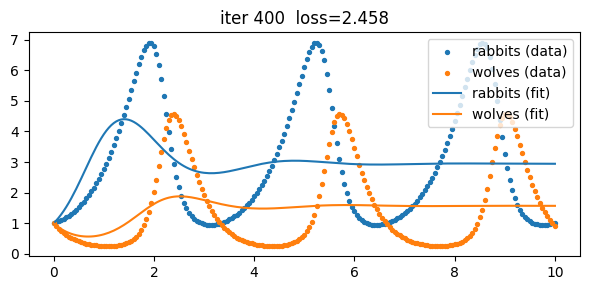

iter  600 | loss=2.298298 | params=[ 2.91773307  1.00273249  2.23737895  0.76306374 -0.40484207]


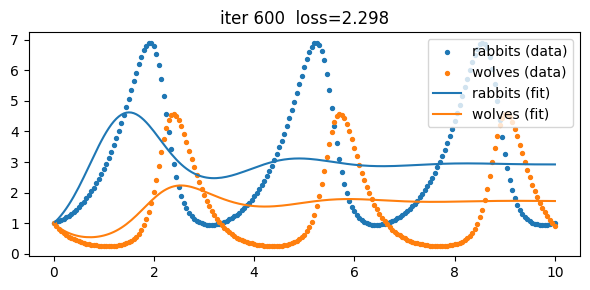

iter  800 | loss=0.832453 | params=[ 1.91122489  0.84708525  2.35875696  0.77615344 -0.09606801]


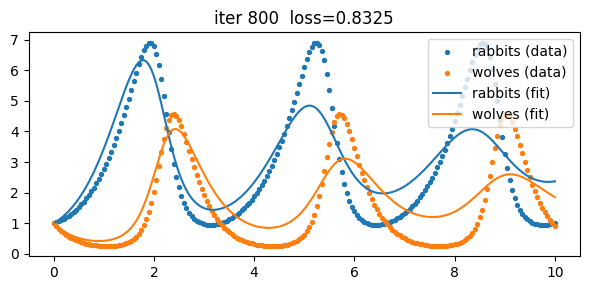

iter 1000 | loss=0.012712 | params=[ 1.60878555e+00  1.06726463e+00  2.71906831e+00  8.96660854e-01
 -1.29563411e-03]


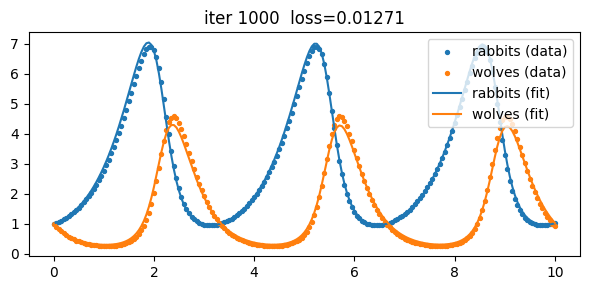


True params   :  [1.5 1.  3.  1.  0. ]
Recovered par.:  [ 1.60878555e+00  1.06726463e+00  2.71906831e+00  8.96660854e-01
 -1.29563411e-03]


In [1]:
import math, torch
import matplotlib.pyplot as plt


device = "cpu"
dtype  = torch.float64  


def f(u, p, t):
    x, y = u[..., 0], u[..., 1]
    alpha, beta, delta, gamma, famma = p
    dx = alpha * x - beta * x * y + famma * x * x
    dy = -delta * y + gamma * x * y
    return torch.stack([dx, dy], dim=-1)

# Simple differentiable RK4 step in torch
# RK4 averages four different slope estimates to get much higher accuracy.
def rk4_step(u, p, t, h):
    k1 = f(u, p, t) #start of interval
    k2 = f(u + 0.5*h*k1, p, t + 0.5*h) # midway through interval 
    k3 = f(u + 0.5*h*k2, p, t + 0.5*h) # better midway apporximation
    k4 = f(u + h*k3,     p, t + h) # end of interval 
    return u + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4) # combine slopes weighted avge

# Integrate over a time grid, returning the full trajectory (saveat)
def solve_ode(u0, p, t0, t1, dt):
    steps = int(round((t1 - t0)/dt))
    ts = torch.linspace(t0, t1, steps + 1, dtype=dtype, device=device)
    us = torch.empty((steps + 1, 2), dtype=dtype, device=device)
    u = u0.clone()
    us[0] = u
    t = t0
    for i in range(steps):
        u = rk4_step(u, p, t, dt)
        t += dt
        us[i+1] = u
    return ts, us


# Generate synthetic data 

u0_true = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
tspan = (0.0, 10.0)
saveat = 0.05

p_true = torch.tensor([1.5, 1.0, 3.0, 1.0, 0.0], dtype=dtype, device=device)  # α β δ γ 
t_data, u_data = solve_ode(u0_true, p_true, tspan[0], tspan[1], saveat)
A1 = u_data[:, 0]  # rabbits
A2 = u_data[:, 1]  # wolves

# show the generated data
plt.figure(figsize=(6,3))
plt.scatter(t_data.cpu(), A1.cpu(), s=8, label="rabbits (data)")
plt.scatter(t_data.cpu(), A2.cpu(), s=8, label="wolves (data)")
plt.legend(); plt.tight_layout(); plt.show()

# Parameter Learning
# Initial guess (matches your Julia: param([4., 1., 2., 0.4]))
p = torch.nn.Parameter(torch.tensor([4.0, 1.0, 2.0, 0.4, 0.05], dtype=dtype, device=device))

optimizer = torch.optim.Adam([p], lr=1e-1)
u0 = u0_true.detach()  # same initial condition used during fitting

# Training loop with a live callback-like plot every N iters
num_iters = 1000
plot_every = 200

for it in range(1, num_iters + 1):
    optimizer.zero_grad()
    _, u_pred = solve_ode(u0, p, tspan[0], tspan[1], saveat)
    loss = torch.mean((u_pred - u_data)**2)  # like sum(abs2, predict - data) scaled
    loss.backward()
    optimizer.step()

    if it % plot_every == 0 or it == 1 or it == num_iters:
        with torch.no_grad():
            print(f"iter {it:4d} | loss={loss.item():.6f} | params={p.data.cpu().numpy()}")
            plt.figure(figsize=(6,3))
            plt.scatter(t_data.cpu(), A1.cpu(), s=8, label="rabbits (data)")
            plt.scatter(t_data.cpu(), A2.cpu(), s=8, label="wolves (data)")
            plt.plot(t_data.cpu(), u_pred[:,0].cpu(), label="rabbits (fit)")
            plt.plot(t_data.cpu(), u_pred[:,1].cpu(), label="wolves (fit)")
            plt.title(f"iter {it}  loss={loss.item():.4g}")
            plt.legend(); plt.tight_layout(); plt.show()

print("\nTrue params   : ", p_true.cpu().numpy())
print("Recovered par.: ", p.detach().cpu().numpy())


In [5]:
import json, torch
import math

device = "cpu"
dtype  = torch.float64

with open("patient_information.json") as f:
    patient = json.load(f)

with open("model.json") as f:
    model = json.load(f)



In [6]:
state_names = list(model["states"].keys())
n_states    = len(state_names)

state_index = {name: i for i, name in enumerate(state_names)}

# Control channels (for Adr, Cyc, Tax, Tam, IO, TIL)
control_channels = model["control_spec"]["channels"]
control_index    = {name: i for i, name in enumerate(control_channels)}

print("States:", state_names)
print("State index:", state_index)
print("Control channels:", control_channels)


States: ['T', 'E', 'H', 'PDL1', 'TGFb', 'ctDNA', 'Adr', 'Cyc', 'Tax', 'Tam', 'IO', 'TIL', 'N', 'BM']
State index: {'T': 0, 'E': 1, 'H': 2, 'PDL1': 3, 'TGFb': 4, 'ctDNA': 5, 'Adr': 6, 'Cyc': 7, 'Tax': 8, 'Tam': 9, 'IO': 10, 'TIL': 11, 'N': 12, 'BM': 13}
Control channels: ['Adr', 'Cyc', 'Tax', 'Tam', 'IO', 'TIL']


In [7]:
def get_initial_state_vector(model, patient, device=device, dtype=dtype):
    ic_patient = patient["initial_conditions"]
    x0 = torch.zeros(n_states, dtype=dtype, device=device)
    for s in state_names:
        x0[state_index[s]] = ic_patient[s]
    return x0

x0 = get_initial_state_vector(model, patient)
x0

tensor([0.1800, 0.3000, 0.5000, 0.5000, 0.0000, 0.0300, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.8000], dtype=torch.float64)

In [8]:
# ------------------------------------------------------------------
# Parameter dictionary theta[name] = torch scalar
# ------------------------------------------------------------------
def get_teacher_params(model, device=device, dtype=dtype):
    theta = {}
    for name, info in model["parameters"].items():
        if "value" in info:
            val = info["value"]
        else:
            val = info.get("initial_guess", 0.0)
        theta[name] = torch.tensor(val, dtype=dtype, device=device)
    return theta

theta = get_teacher_params(model)
list(theta.items())[:10]   # peek at first few


[('rT_max', tensor(0.0500, dtype=torch.float64)),
 ('k_ET', tensor(0.5000, dtype=torch.float64)),
 ('K_ET', tensor(0.2000, dtype=torch.float64)),
 ('k_Tam_ERPR', tensor(0.3000, dtype=torch.float64)),
 ('K_Tam', tensor(0.3000, dtype=torch.float64)),
 ('rE_max', tensor(0.1000, dtype=torch.float64)),
 ('rH_max', tensor(0.0600, dtype=torch.float64)),
 ('delta_E', tensor(0.0300, dtype=torch.float64)),
 ('delta_H', tensor(0.0200, dtype=torch.float64)),
 ('k_T_to_E', tensor(0.2000, dtype=torch.float64))]

In [9]:
# ------------------------------------------------------------------
# Helper functions: Hill, Sat, resource factors
# ------------------------------------------------------------------
eps = 1e-8

def Hill(x, K, n):
    # x, K, n can be scalars/tensors; broadcasting works
    return x**n / (K**n + x**n + eps)

def Sat(x, K):
    return x / (K + x + eps)

def g_N(N, theta):
    # g_N(N) = Sat(N; K_N_prolif)
    return Sat(N, theta["K_N_prolif"])

def g_BM(BM, theta):
    # g_BM(BM) = BM^n_BM / (K_BM^n_BM + BM^n_BM + eps)
    n_BM = theta["n_BM"]
    K_BM = theta["K_BM"]
    return BM**n_BM / (K_BM**n_BM + BM**n_BM + eps)

def g_TGFb(TGFb, theta):
    # g_TGFb(TGFb) = Hill(TGFb; K_TGFb, n_TGFb)
    return Hill(TGFb, theta["K_TGFb"], theta["n_TGFb"])

def S_IO(IO, theta):
    return Hill(IO, theta["K_IO"], theta["n_IO"])

def S_PDL1(PDL1, theta):
    return Hill(PDL1, theta["K_PDL1"], theta["n_PDL1"])

def S_Adr(Adr, theta):
    return theta["Emax_Adr"] * Hill(Adr, theta["EC50_Adr"], theta["n_Adr"])

def S_Cyc(Cyc, theta):
    return theta["Emax_Cyc"] * Hill(Cyc, theta["EC50_Cyc"], theta["n_Cyc"])

def S_Tax(Tax, theta):
    return theta["Emax_Tax"] * Hill(Tax, theta["EC50_Tax"], theta["n_Tax"])


In [10]:
def zero_control_schedule(t):
    return {name: torch.tensor(0.0, dtype=dtype, device=device)
            for name in control_channels}

u_schedule = zero_control_schedule

In [11]:
# ------------------------------------------------------------------
# Teacher ODE: f_teacher(x, t, theta, u_fn)
# x has shape (..., n_states)
# ------------------------------------------------------------------
def f_teacher(x, t, theta, u_fn):
    # Unpack state vector in your canonical order
    T    = x[..., state_index["T"]]
    E    = x[..., state_index["E"]]
    H    = x[..., state_index["H"]]
    PDL1 = x[..., state_index["PDL1"]]
    TGFb = x[..., state_index["TGFb"]]
    ct   = x[..., state_index["ctDNA"]]
    Adr  = x[..., state_index["Adr"]]
    Cyc  = x[..., state_index["Cyc"]]
    Tax  = x[..., state_index["Tax"]]
    Tam  = x[..., state_index["Tam"]]
    IO   = x[..., state_index["IO"]]
    TIL  = x[..., state_index["TIL"]]
    N    = x[..., state_index["N"]]
    BM   = x[..., state_index["BM"]]

    # Controls u_Drug(t)
    u = u_fn(t)
    u_Adr = u.get("Adr", torch.tensor(0.0, dtype=dtype, device=device))
    u_Cyc = u.get("Cyc", torch.tensor(0.0, dtype=dtype, device=device))
    u_Tax = u.get("Tax", torch.tensor(0.0, dtype=dtype, device=device))
    u_Tam = u.get("Tam", torch.tensor(0.0, dtype=dtype, device=device))
    u_IO  = u.get("IO",  torch.tensor(0.0, dtype=dtype, device=device))
    u_TIL = u.get("TIL", torch.tensor(0.0, dtype=dtype, device=device))

    # Helper factors
    gN   = g_N(N, theta)
    gBM  = g_BM(BM, theta)
    gTGF = g_TGFb(TGFb, theta)
    SP   = S_PDL1(PDL1, theta)
    SIO  = S_IO(IO, theta)

    SAdr   = S_Adr(Adr, theta)
    SCyc   = S_Cyc(Cyc, theta)
    STax   = S_Tax(Tax, theta)
    Schemo = SAdr + SCyc + STax

    # --------------------------------------------------------------
    # 1) Tumor T
    # --------------------------------------------------------------
    rT_max      = theta["rT_max"]
    k_ET        = theta["k_ET"]
    K_ET        = theta["K_ET"]
    k_PDboost_T = theta["k_PDboost_T"]
    k_Tam_ERPR  = theta["k_Tam_ERPR"]
    K_Tam       = theta["K_Tam"]

    growth_T = rT_max * gN * (1.0 + k_PDboost_T * SP) * T * (1.0 - T)
    kill_E   = k_ET * (E * T) / (K_ET + T + eps)
    kill_ch  = Schemo * T
    kill_Tam = k_Tam_ERPR * Sat(Tam, K_Tam) * T

    dT = growth_T - kill_E - kill_ch - kill_Tam

    # --------------------------------------------------------------
    # 2) Effector E
    # --------------------------------------------------------------
    rE_max    = theta["rE_max"]
    delta_E   = theta["delta_E"]
    k_T_to_E  = theta["k_T_to_E"]
    K_Tstim_E = theta["K_Tstim_E"]
    k_H_to_E  = theta["k_H_to_E"]
    K_Hboost_E= theta["K_Hboost_E"]
    phi_TGFb  = theta["phi_TGFb"]
    gamma_IO  = theta["gamma_IO"]

    Stim_E_from_T = k_T_to_E * Sat(T, K_Tstim_E) * E
    Stim_E_from_H = k_H_to_E * Sat(H, K_Hboost_E) * E

    Growth_E = rE_max * gN * gBM * (1.0 - phi_TGFb * gTGF) * (1.0 + gamma_IO * SIO) * E
    Loss_E   = delta_E * (1.0 + SP) * E

    dE = Growth_E + Stim_E_from_T + Stim_E_from_H - Loss_E

    # --------------------------------------------------------------
    # 3) Helper H
    # --------------------------------------------------------------
    rH_max     = theta["rH_max"]
    delta_H    = theta["delta_H"]
    k_T_to_H   = theta["k_T_to_H"]
    K_Tstim_H  = theta["K_Tstim_H"]

    Stim_H_from_T = k_T_to_H * Sat(T, K_Tstim_H) * H
    Growth_H      = rH_max * gN * gBM * (1.0 - phi_TGFb * gTGF) * H
    Loss_H        = delta_H * H

    dH = Growth_H + Stim_H_from_T - Loss_H

    # --------------------------------------------------------------
    # 4) PD-L1
    # --------------------------------------------------------------
    PDL1_basal   = theta["PDL1_basal"]
    k_PDL1_up_T  = theta["k_PDL1_up_T"]
    K_PDL1_up_T  = theta["K_PDL1_up_T"]
    k_PDL1_up_E  = theta["k_PDL1_up_E"]
    K_PDL1_up_E  = theta["K_PDL1_up_E"]
    k_PDL1_decay = theta["k_PDL1_decay"]
    k_IO_block   = theta["k_IO_block_PDL1"]

    dPDL1 = (
        PDL1_basal
        + k_PDL1_up_T * Sat(T, K_PDL1_up_T)
        + k_PDL1_up_E * Sat(E, K_PDL1_up_E)
        - k_PDL1_decay * PDL1
        - k_IO_block * SIO * PDL1
    )

    # --------------------------------------------------------------
    # 5) TGFb
    # --------------------------------------------------------------
    k_T_secrete_TGFb = theta["k_T_secrete_TGFb"]
    k_TGFb_decay     = theta["k_TGFb_decay"]

    dTGFb = k_T_secrete_TGFb * T - k_TGFb_decay * TGFb

    # --------------------------------------------------------------
    # 6) ctDNA
    # --------------------------------------------------------------
    p_ct    = theta["p_ct"]
    k_ctclr = theta["k_ctclr"]

    dct = p_ct * T - k_ctclr * ct

    # --------------------------------------------------------------
    # 7) Nutrient N
    # --------------------------------------------------------------
    sN           = theta["sN"]
    dN           = theta["dN"]
    K_N_use_T    = theta["K_N_use_T"]
    K_N_use_E    = theta["K_N_use_E"]
    chi_N_chemo  = theta["chi_N_chemo"]

    Tumor_use = N * T / (K_N_use_T + T + eps)
    Eff_use   = N * E / (K_N_use_E + E + eps)

    dNdt = (
        sN
        - dN * N
        - Tumor_use
        - Eff_use
        - chi_N_chemo * Schemo * N
    )

    # --------------------------------------------------------------
    # 8) Bone marrow BM
    # --------------------------------------------------------------
    sBM         = theta["sBM"]
    dBM         = theta["dBM"]
    qBM_chemo   = theta["qBM_chemo"]
    gamma_BM_IO = theta["gamma_BM_IO"]
    gamma_BM_TIL= theta["gamma_BM_TIL"]
    K_TIL       = theta["K_TIL"]

    Support_IO  = gamma_BM_IO  * SIO * (1.0 - BM)
    Support_TIL = gamma_BM_TIL * Sat(TIL, K_TIL) * (1.0 - BM)

    dBMdt = (
        sBM
        - dBM * BM
        - qBM_chemo * Schemo * BM
        + Support_IO
        + Support_TIL
    )

    # --------------------------------------------------------------
    # 9) Drug PK
    # --------------------------------------------------------------
    lambda_Adr = theta["lambda_Adr"]
    lambda_Cyc = theta["lambda_Cyc"]
    lambda_Tax = theta["lambda_Tax"]
    lambda_Tam = theta["lambda_Tam"]
    lambda_IO  = theta["lambda_IO"]
    lambda_TIL = theta["lambda_TIL"]

    dAdr = u_Adr - lambda_Adr * Adr
    dCyc = u_Cyc - lambda_Cyc * Cyc
    dTax = u_Tax - lambda_Tax * Tax
    dTam = u_Tam - lambda_Tam * Tam
    dIO  = u_IO  - lambda_IO  * IO
    dTIL = u_TIL - lambda_TIL * TIL

    # --------------------------------------------------------------
    # Pack derivatives back into a tensor of shape (..., n_states)
    # --------------------------------------------------------------
    dxdt = torch.stack([
        dT, dE, dH, dPDL1, dTGFb, dct,
        dAdr, dCyc, dTax, dTam, dIO, dTIL,
        dNdt, dBMdt
    ], dim=-1)

    return dxdt

In [12]:
# ------------------------------------------------------------------
# Differentiable RK4 integrator
# ------------------------------------------------------------------
def rk4_step(f, x, t, dt, theta, u_fn):
    k1 = f(x,           t,           theta, u_fn)
    k2 = f(x + 0.5*dt*k1, t + 0.5*dt, theta, u_fn)
    k3 = f(x + 0.5*dt*k2, t + 0.5*dt, theta, u_fn)
    k4 = f(x + dt*k3,     t + dt,     theta, u_fn)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# Indices to clamp in [0,1] (T, PDL1, TGFb, ctDNA, N, BM)
clamp_indices = [
    state_index["T"],
    state_index["PDL1"],
    state_index["TGFb"],
    state_index["ctDNA"],
    state_index["N"],
    state_index["BM"],
]

def clamp_states(x):
    x_cl = x.clone()
    x_cl[..., clamp_indices] = x_cl[..., clamp_indices].clamp(0.0, 1.0)
    return x_cl


In [15]:
import math

# ------------------------------------------------------------------
# Simple AC-T + IO/TIL toy schedule (for simulations only, NOT clinical)
# ------------------------------------------------------------------
t0_sim   = patient["tgrid"]["start_day"]
dt_sim   = patient["tgrid"]["step_days"]
num_days = patient["tgrid"]["num_days"]
t_end_sim = t0_sim + dt_sim * (num_days - 1)

def square_pulse(t, center_day, width_days, amplitude):
    """
    Square pulse of height 'amplitude' active for |t - center| <= width/2.
    t can be a scalar or 0-D tensor.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(float(t), dtype=dtype, device=device)

    center = torch.tensor(center_day, dtype=dtype, device=device)
    width  = torch.tensor(width_days, dtype=dtype, device=device)
    amp    = torch.tensor(amplitude, dtype=dtype, device=device)

    inside = torch.abs(t - center) <= 0.5 * width
    return amp * inside.to(dtype)

def ac_t_io_til_schedule(t):
    """
    Toy AC-T + IO/TIL schedule:
      - 4 Adr + Cyc pulses q21d (cycles 0-3)
      - 4 Tax pulses q21d (cycles 4-7)
      - Tam: low continuous daily after first Adr cycle starts
      - IO: infusions q21d through entire horizon
      - TIL: single early bolus

    This is ONLY for simulation excitation, NOT a clinical regimen.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(float(t), dtype=dtype, device=device)

    cycle_len = 21.0   # days between big chemo cycles

    Adr_dose  = 1.0
    Cyc_dose  = 1.0
    Tax_dose  = 1.0
    Tam_dose  = 0.2    # smaller but continuous
    IO_dose   = 0.5
    TIL_dose  = 1.0

    # Adr + Cyc: cycles 0-3
    u_Adr = torch.tensor(0.0, dtype=dtype, device=device)
    u_Cyc = torch.tensor(0.0, dtype=dtype, device=device)
    for k in range(4):
        center = t0_sim + k * cycle_len
        u_Adr = u_Adr + square_pulse(t, center, 1.0, Adr_dose)
        u_Cyc = u_Cyc + square_pulse(t, center, 1.0, Cyc_dose)

    # Tax: cycles 4-7
    u_Tax = torch.tensor(0.0, dtype=dtype, device=device)
    for k in range(4, 8):
        center = t0_sim + k * cycle_len
        u_Tax = u_Tax + square_pulse(t, center, 1.0, Tax_dose)

    # Tam: low constant dose after first Adr dose
    tam_start = t0_sim
    u_Tam = torch.where(
        t >= tam_start,
        torch.tensor(Tam_dose, dtype=dtype, device=device),
        torch.tensor(0.0, dtype=dtype, device=device)
    )

    # IO: infusions q21d across horizon
    u_IO = torch.tensor(0.0, dtype=dtype, device=device)
    num_cycles = int(math.ceil((t_end_sim - t0_sim) / cycle_len)) + 1
    for k in range(num_cycles):
        center = t0_sim + k * cycle_len
        u_IO = u_IO + square_pulse(t, center, 1.0, IO_dose)

    # TIL: one early bolus (e.g., day 10)
    til_center = t0_sim + 10.0
    u_TIL = square_pulse(t, til_center, 1.0, TIL_dose)

    return {
        "Adr": u_Adr,
        "Cyc": u_Cyc,
        "Tax": u_Tax,
        "Tam": u_Tam,
        "IO":  u_IO,
        "TIL": u_TIL,
    }

# Use this as your control schedule in the simulation
u_schedule = ac_t_io_til_schedule


In [13]:
# ------------------------------------------------------------------
# Teacher simulation -> x_data [T, n_states]
# ------------------------------------------------------------------
def simulate_teacher(model, patient, theta, u_fn, device=device, dtype=dtype):
    tgrid = patient["tgrid"]
    t0    = tgrid["start_day"]
    num   = tgrid["num_days"]
    dt    = tgrid["step_days"]

    times = torch.linspace(t0, t0 + dt*(num - 1),
                           steps=num, dtype=dtype, device=device)

    x = torch.zeros(num, n_states, dtype=dtype, device=device)
    x[0] = get_initial_state_vector(model, patient, device=device, dtype=dtype)

    for i in range(num - 1):
        t = times[i]
        x_next = rk4_step(f_teacher, x[i], t, dt, theta, u_fn)
        x[i+1] = clamp_states(x_next)

    return times, x

times, x_data = simulate_teacher(model, patient, theta, u_schedule)
x_data.shape, times.shape


(torch.Size([365, 14]), torch.Size([365]))

In [16]:
times, x_data = simulate_teacher(model, patient, theta, u_schedule)


KeyboardInterrupt: 